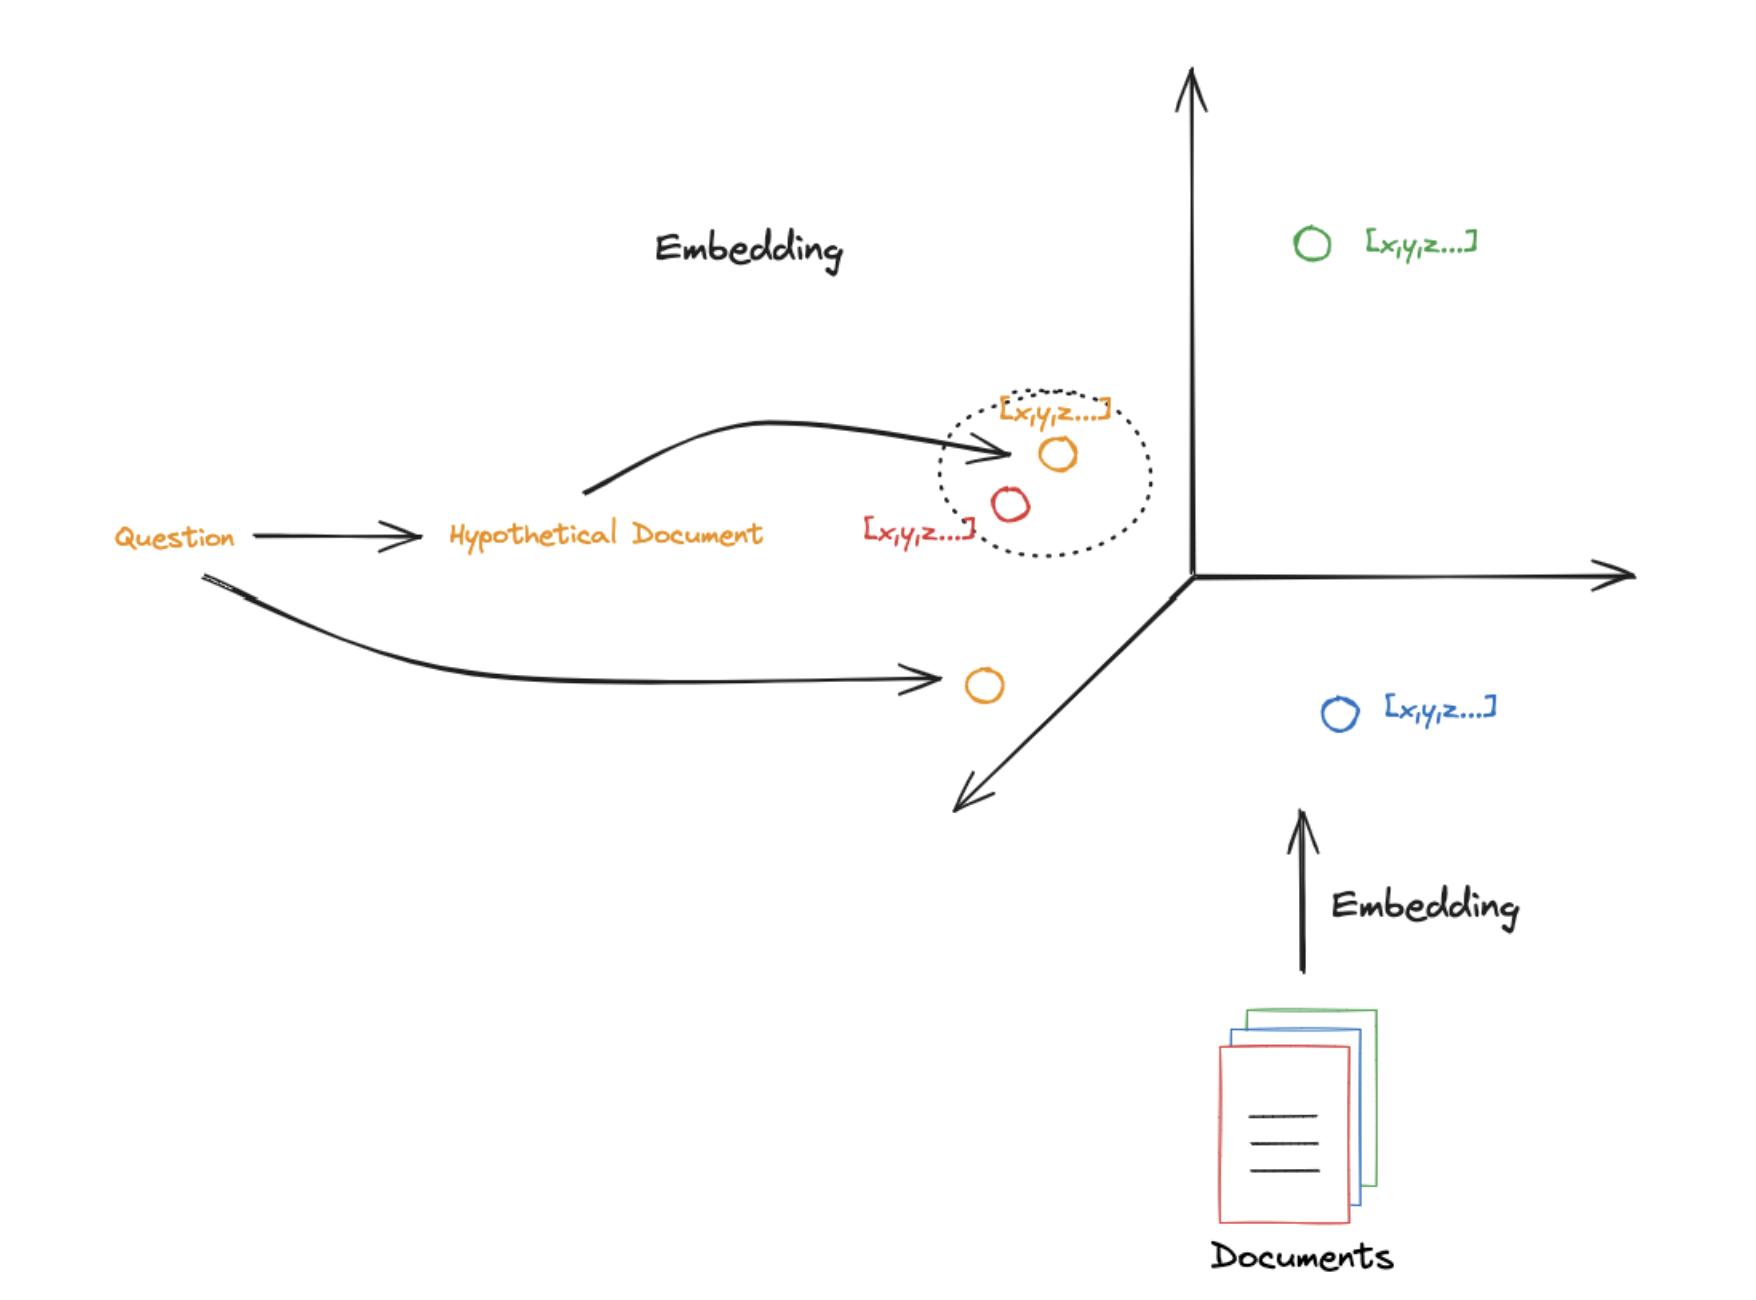

In [ ]:
from langchain.prompts import ChatPromptTemplate

import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(documents)

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [ ]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
# generate_docs_for_retrieval.invoke({"question":question})

# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
# retireved_docs = retrieval_chain.invoke({"question":question})
# retireved_docs

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {
    "context":generate_docs_for_retrieval | retriever,
    "question":RunnablePassthrough()
    }
    |prompt
    | ChatOpenAI()
    | StrOutputParser()
)

final_rag_chain.invoke({'question':question})